In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("bank_data.csv")

In [3]:
print (df.head())

     id  expected_recovery_amount  actual_recovery_amount recovery_strategy  \
0  2030                       194                 263.540  Level 0 Recovery   
1  1150                       486                 416.090  Level 0 Recovery   
2   380                       527                 429.350  Level 0 Recovery   
3  1838                       536                 296.990  Level 0 Recovery   
4  1995                       541                 346.385  Level 0 Recovery   

   age     sex  
0   19    Male  
1   25  Female  
2   27    Male  
3   25    Male  
4   34    Male  


# Graphical EDA

In [4]:
select_range = (df['expected_recovery_amount'] >= 0) & (df['expected_recovery_amount'] <= 2000)
data = df[select_range]

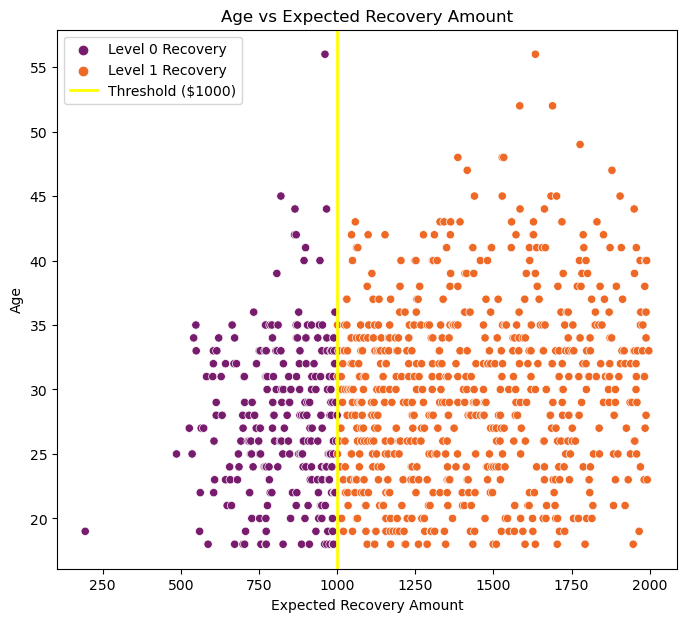

In [5]:
# For visualizing relationship we will create a scatter plot
plt.figure(figsize=(8, 7))
sns.scatterplot(x='expected_recovery_amount', y='age', data=data, hue='recovery_strategy', palette='inferno')
plt.axvline(x=1000, color='yellow', linestyle='-', linewidth=2, label='Threshold ($1000)')
plt.title('Age vs Expected Recovery Amount')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.legend()
plt.show()



# Statistical test: age vs. expected recovery amount


We will first check normality before working on data . So we will make use of Shapiro wilk test to calculate above and before threshold value

In [6]:
from scipy.stats import shapiro

above_threshold_age = df[(df['expected_recovery_amount'] > 1000) & (df['expected_recovery_amount'] <= 1100)]['age']
below_threshold_age = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] < 1000)]['age']
shapiro_above = shapiro(above_threshold_age)  #checking for shapiro test for nomality
shapiro_below = shapiro(below_threshold_age)

print("Above Threshold - Shapiro Statistic:", shapiro_above.statistic, ", p-value:", shapiro_above.pvalue)
print("Below Threshold - Shapiro Statistic:", shapiro_below.statistic, ", p-value:", shapiro_below.pvalue)

Above Threshold - Shapiro Statistic: 0.9733968377113342 , p-value: 0.04987287148833275
Below Threshold - Shapiro Statistic: 0.9212198257446289 , p-value: 4.9966114602284506e-05


The Shapiro-Wilk test results for age data, both above and below the $1000 threshold, show p-values below the standard significance level of 0.05. This indicates that the age distributions in both groups are unlikely to be normal.

In [7]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
mannwhitney_result = mannwhitneyu(above_threshold_age, below_threshold_age)

print("Mann-Whitney U Statistic:", mannwhitney_result.statistic, ", p-value:", mannwhitney_result.pvalue)

Mann-Whitney U Statistic: 4815.5 , p-value: 0.07570884886849544


The very small p-value suggests strong evidence to reject the idea that there's no age difference between customers above and below the $1000 threshold. This says the notion that age is systematically related to the expected recovery amount.

# Statistical test: sex vs. expected recovery amount

In [8]:
from scipy.stats import chi2_contingency

df['within_range'] = pd.cut(df['expected_recovery_amount'], bins=[900, 1100], labels=['Within Range'])

# To analyze the relationship between two categorical variables we create  a contingency table
contingency_table = pd.crosstab(df['sex'], df['within_range'])
chi2, p, _, _ = chi2_contingency(contingency_table) #chi-square test
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-value: {p}")

# Using if-else loop for testing hypothesis
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis. There is a significant difference in gender distribution within the specified range.")
else:
    print("Fail to reject the null hypothesis. No significant difference in gender distribution within the specified range.")


Chi-Squared Statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis. No significant difference in gender distribution within the specified range.


The p-value of 1.0 provides strong evidence in favor of the null hypothesis, suggesting that there is no significant difference in gender distribution within the specified range. In statistical terms, this implies that the observed data is highly consistent with the assumption that the proportion of male customers is the same as the proportion of female customers in the analyzed range (from 900 to 1100).

Practically, this indicates that there is no observable shift or abrupt change in the percentage of male customers compared to female customers within the specified range. The gender distribution remains statistically consistent across the entire range from 900 to 1100.

# EDA: Recovery Amt

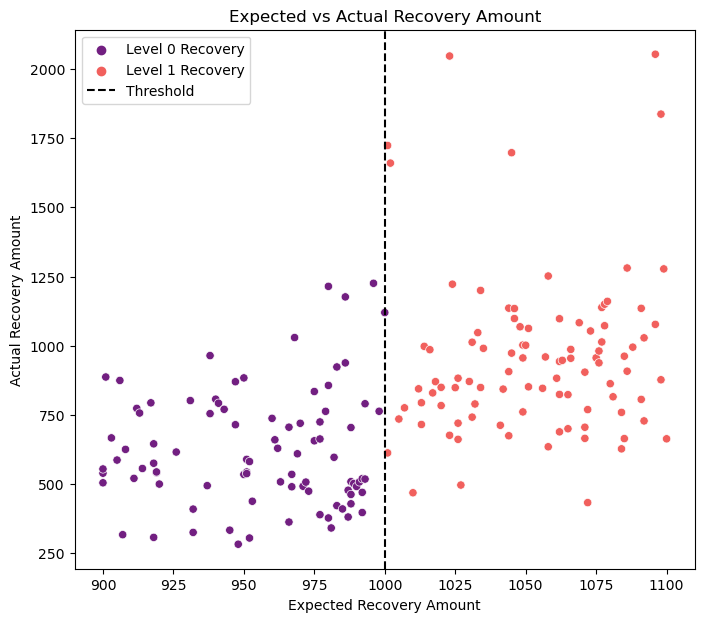

In [9]:
filter_data = df[(df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)]


plt.figure(figsize=(8, 7))
sns.scatterplot(x='expected_recovery_amount', y='actual_recovery_amount', data=filter_data, hue='recovery_strategy', palette='magma')
plt.title('Expected vs Actual Recovery Amount')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.axvline(x=1000, color='black', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Around the $1000 threshold, we notice a jump in the way actual recovery amounts behave compared to expected recovery amounts between $900 and $1100.

For customers with expected recovery amounts below $1000, the actual recovery amounts tend to be closer together, forming a more concentrated group. However, for expected recovery amounts above $1000, the actual recovery amounts are more spread out, indicating a wider range of values.

In simpler terms, it suggests that there's a difference in how much money customers are actually recovering, depending on whether their expected recovery amount is below or above $1000. The data shows a distinct change in behavior around this threshold.

In [10]:
from scipy.stats import kruskal
range1 = (df['expected_recovery_amount'] >= 900) & (df['expected_recovery_amount'] <= 1100)
range2 = (df['expected_recovery_amount'] >= 950) & (df['expected_recovery_amount'] <= 1050)

# to get significant differences between the medians of three or more independent groups use krushal test
statistic1, p_value1 = kruskal(df[range1]['actual_recovery_amount'], df[~range1]['actual_recovery_amount'])
statistic2, p_value2 = kruskal(df[range2]['actual_recovery_amount'], df[~range2]['actual_recovery_amount'])

print(f"range 1 - Kruskal-Wallis Statistic: {statistic1}, p-value: {p_value1}")
print(f"range 2 - Kruskal-Wallis Statistic: {statistic2}, p-value: {p_value2}")

range 1 - Kruskal-Wallis Statistic: 280.1566884758695, p-value: 6.94146340689006e-63
range 2 - Kruskal-Wallis Statistic: 151.38798031653096, p-value: 8.621627850497973e-35


The Kruskal-Wallis test results indicate statistically significant differences in the distribution of actual recovery amounts between the specified windows and the rest of the data. The p-values are very close to zero, suggesting strong evidence against the null hypothesis that the distributions are the same.

# Regression modeling: no threshold

In [11]:
import statsmodels.api as sm
import pandas as pd
X = df[['expected_recovery_amount']]
y = df['actual_recovery_amount']

X = sm.add_constant(X) #adding constant terms
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.817
Model:                                OLS   Adj. R-squared:                  0.817
Method:                     Least Squares   F-statistic:                     8378.
Date:                    Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                            02:45:26   Log-Likelihood:                -16936.
No. Observations:                    1882   AIC:                         3.388e+04
Df Residuals:                        1880   BIC:                         3.389e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Regression modeling: adding true threshold

In [12]:
df['above_threshold'] = (df['expected_recovery_amount'] > 1000).astype(int)

#make use of indicator for threshold value
model_with_threshold = sm.OLS(df['actual_recovery_amount'], sm.add_constant(df[['expected_recovery_amount', 'above_threshold']])).fit()
print(model_with_threshold.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.819
Model:                                OLS   Adj. R-squared:                  0.818
Method:                     Least Squares   F-statistic:                     4242.
Date:                    Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                            02:45:26   Log-Likelihood:                -16926.
No. Observations:                    1882   AIC:                         3.386e+04
Df Residuals:                        1879   BIC:                         3.387e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Regression modeling: adjusting the range

In [13]:

range_data = df[(df['expected_recovery_amount'] >= 950) & (df['expected_recovery_amount'] <= 1050)]
range_data['above_threshold'] = (range_data['expected_recovery_amount'] > 1000).astype(int)

# Performing OLS regression
model_range= sm.OLS(range_data['actual_recovery_amount'], sm.add_constant(range_data[['expected_recovery_amount', 'above_threshold']]))
results_range_data = model_range.fit()

# Print regression results
print(results_range_data.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.270
Model:                                OLS   Adj. R-squared:                  0.255
Method:                     Least Squares   F-statistic:                     17.90
Date:                    Wed, 24 Jan 2024   Prob (F-statistic):           2.42e-07
Time:                            02:45:26   Log-Likelihood:                -700.65
No. Observations:                     100   AIC:                             1407.
Df Residuals:                          97   BIC:                             1415.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

C:\Users\pushk\AppData\Local\Temp\ipykernel_24420\4248460372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  range_data['above_threshold'] = (range_data['expected_recovery_amount'] > 1000).astype(int)
